## Table Of Contents:
* [1.Reading the data](#first-bullet)
* [2. Modelling with LightGBM](#second-bullet)
* [3. Features importance](#third-bullet)

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn import neighbors

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix 
import pylab as pl
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

from sklearn.preprocessing import MinMaxScaler
# imputer for handling missing values
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pickle

## <font color="blue"> 1. Reading the data <a class="anchor" id="first-bullet"></a>

In [2]:
# Training data
app_train_domain = pd.read_csv('../input/app_train_domain.csv')
print('Training data shape: ', app_train_domain.shape)
app_train_domain.head()

Training data shape:  (307511, 219)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,1,0,1,False,2.007889,0.121978,16.461104,-0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,1,0,0,False,4.790750,0.132217,36.234085,-0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,False,2.000000,0.100000,20.000000,-0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,False,2.316167,0.219900,10.532818,-0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,False,4.222222,0.179963,23.461618,-0.152418


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [3]:
# Testing data features
app_test_domain = pd.read_csv('../input/app_test_domain.csv')
print('Testing data shape: ', app_test_domain.shape)
app_test_domain.head()

Testing data shape:  (48744, 218)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,1,0,1,0,False,4.213333,0.152300,27.664697,0.121044
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,False,2.250182,0.175455,12.824870,0.247398
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,False,3.275378,0.344578,9.505482,0.222477
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,1,0,0,1,0,False,5.000000,0.155614,32.130726,0.133515
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,False,3.475000,0.178150,19.506034,0.168021


The test set is considerably smaller and lacks a `TARGET` column. 

## <font color="blue"> 2. Modelling with LightGBM <a class="anchor" id="second-bullet"></a>

In [4]:
# Feature names
features = list(app_train_domain.columns)

feats = [f for f in app_train_domain.columns if f not in ['TARGET','SK_ID_CURR',
                                                      'SK_ID_BUREAU','SK_ID_PREV','index']]
X = app_train_domain[feats]
Y = app_train_domain['TARGET']
#Split the train data in train and test set
X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.2,random_state=1)

X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)
X_test = pd.DataFrame(X_test)
Y_test = pd.DataFrame(Y_test)

X_train.columns = feats
Y_train.columns = ['TARGET']
X_test.columns = feats
Y_test.columns = ['TARGET']

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (246008, 217)
Testing data shape:  (61503, 217)


In [5]:
#Define my own evalution metric to reflect the business needs. Granting the loan to a customer that will not repay it is more 
# costly than not granting the loan to a customer that would have repay it. 
def own_eval_metric(y_true, y_pred):
    TN_cost = 0
    TP_cost = 1
    FP_cost = -1
    FN_cost = -10
    treshold = [0.08]
    score = []
   
    nb_positif = sum(y_true)
    nb_negatif = len(y_true) - nb_positif
   
    best_cost = nb_negatif*TN_cost + nb_positif*TP_cost #The best possible score. No classification error
    worst_cost= nb_positif*FN_cost + nb_negatif*FP_cost # The worst possible score. All credits are wrongly classified
    base_cost = nb_negatif*TN_cost + nb_positif*FN_cost #The base score if all laons are classified as being repaid
 
    #if the predicted value is below the treshold, 
    #the loan application is classified as 0 (no payment difficulties) else it is classified as 1 (payment difficulties)
    for t in range(0,len(treshold)) :
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        y_pred_cm = []
        for i in range(0,len(y_true)):
            if y_pred[i]<=treshold[t]:
                y_pred_cm.append(0)
            else:
                y_pred_cm.append(1)
        
    
        cm = confusion_matrix(y_true, y_pred_cm)
       
        TN = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TP = cm[1][1]
      
        cost= TP*TP_cost+ TN*TN_cost + FP*FP_cost + FN*FN_cost
        score_l = (cost - base_cost)/(best_cost - base_cost)
      
        score.append(score_l)
    
    max_score = max(score)
    max_score_index =  score.index(max_score)
    print("max :",max_score)
    print("treshold ",treshold[max_score_index])
    return ('own_eval_metric',max_score, True)

In [6]:
# Light Gradient Boosting model
def model_select_hyperparameters(X_train,Y_train, n_folds = 3):
    
   
    # LightGBMError: Do not support special JSON characters
    import re
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(X_train.columns))
    
    # Create the kfold object
    k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1001)
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(X_train.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
  
    
    model = lgb.LGBMClassifier(
            boosting_type='goss',
            n_estimators=6000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            #scale_pos_weight=11,
            metric='custom', first_metric_only = True,
            silent=-1,
            verbose=-1 )  
     
   
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(X_train,Y_train):
    
        # Training data for the fold
        train_features, train_labels =  X_train.iloc[train_indices], Y_train.iloc[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = X_train.iloc[valid_indices], Y_train.iloc[valid_indices]
        
      
        # Train the model
        model.fit(train_features, train_labels, eval_metric = own_eval_metric,
                  eval_set = [(train_features, train_labels),(valid_features, valid_labels)],
                  eval_names = ['train', 'valid'], 
                  early_stopping_rounds = 100, verbose = 10)
             
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['own_eval_metric']
        train_score = model.best_score_['train']['own_eval_metric']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        # Clean up memory
        gc.enable()
        del train_features, train_labels, valid_features, valid_labels
        gc.collect()
 

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance_values})
    print(valid_scores)
    print(train_scores)
    return  feature_importances, out_of_fold

In [7]:
fi_cv, prediction_prob_cv = model_select_hyperparameters(X_train, Y_train)


max : 0.19859622133551272
treshold  0.08
max : 0.18878265886425452
treshold  0.08
Training until validation scores don't improve for 100 rounds
max : 0.3039208279821712
treshold  0.08
max : 0.2882222039067007
treshold  0.08
max : 0.32006016194276377
treshold  0.08
max : 0.30326382592928375
treshold  0.08
max : 0.32769715741688243
treshold  0.08
max : 0.3107915052611335
treshold  0.08
max : 0.3285144258174401
treshold  0.08
max : 0.3106816121322014
treshold  0.08
max : 0.3292630162011442
treshold  0.08
max : 0.31129976098244455
treshold  0.08
max : 0.3316942179977611
treshold  0.08
max : 0.3139509327179318
treshold  0.08
max : 0.3319071198500072
treshold  0.08
max : 0.311684386933707
treshold  0.08
max : 0.3321886997191069
treshold  0.08
max : 0.3139097227945823
treshold  0.08
max : 0.33492895259156497
treshold  0.08
max : 0.3155718563696805
treshold  0.08
[10]	train's own_eval_metric: 0.334929	valid's own_eval_metric: 0.315572
max : 0.3345031488870727
treshold  0.08
max : 0.31525591362

max : 0.3763692679610184
treshold  0.08
max : 0.3430588752438254
treshold  0.08
max : 0.3770354447244981
treshold  0.08
max : 0.3428802989093107
treshold  0.08
max : 0.37741317381719286
treshold  0.08
max : 0.3428665622681942
treshold  0.08
max : 0.37820983881269443
treshold  0.08
max : 0.3442402263798456
treshold  0.08
max : 0.3786974527323549
treshold  0.08
max : 0.344597379048875
treshold  0.08
max : 0.3781892354076384
treshold  0.08
max : 0.3447759553833897
treshold  0.08
max : 0.378642510318872
treshold  0.08
max : 0.34430890958542815
treshold  0.08
[100]	train's own_eval_metric: 0.378643	valid's own_eval_metric: 0.344309
max : 0.37933615828909323
treshold  0.08
max : 0.3443363828676612
treshold  0.08
max : 0.3794117041076322
treshold  0.08
max : 0.34524300118135115
treshold  0.08
max : 0.3802907827233581
treshold  0.08
max : 0.34565510041484654
treshold  0.08
max : 0.3803045183267288
treshold  0.08
max : 0.34581994010824474
treshold  0.08
max : 0.380462477765492
treshold  0.08
ma

max : 0.40592141861311615
treshold  0.08
max : 0.3616720239567021
treshold  0.08
max : 0.40630601550749623
treshold  0.08
max : 0.36183686365010026
treshold  0.08
max : 0.4068691752456956
treshold  0.08
max : 0.36267479875820763
treshold  0.08
[190]	train's own_eval_metric: 0.406869	valid's own_eval_metric: 0.362675
max : 0.40729497895018785
treshold  0.08
max : 0.3627297453226737
treshold  0.08
max : 0.4078787420934433
treshold  0.08
max : 0.3623451193714113
treshold  0.08
max : 0.40749414519906324
treshold  0.08
max : 0.3631418445561691
treshold  0.08
max : 0.40783753528333117
treshold  0.08
max : 0.36315558119728564
treshold  0.08
max : 0.407892477696814
treshold  0.08
max : 0.3631693178384022
treshold  0.08
max : 0.40812598295411623
treshold  0.08
max : 0.36318305447951865
treshold  0.08
max : 0.40838695941815983
treshold  0.08
max : 0.36347152394296545
treshold  0.08
max : 0.4085929934687206
treshold  0.08
max : 0.3638149399708783
treshold  0.08
max : 0.4090462683799543
treshold  

max : 0.42515126333212
treshold  0.08
max : 0.3706557872469024
treshold  0.08
max : 0.4251375277287493
treshold  0.08
max : 0.37024368801340696
treshold  0.08
max : 0.4255358602265001
treshold  0.08
max : 0.37072447045248497
treshold  0.08
max : 0.4253366939776247
treshold  0.08
max : 0.3702299513722904
treshold  0.08
max : 0.42546031440796117
treshold  0.08
max : 0.37087557350476663
treshold  0.08
max : 0.42539163639110755
treshold  0.08
max : 0.3710266765570483
treshold  0.08
max : 0.42583804350065585
treshold  0.08
max : 0.3715486689194758
treshold  0.08
max : 0.4257693654838023
treshold  0.08
max : 0.37187834830627214
treshold  0.08
max : 0.4258311756989705
treshold  0.08
max : 0.3718096651006896
treshold  0.08
max : 0.4260372097495313
treshold  0.08
max : 0.37087557350476663
treshold  0.08
[290]	train's own_eval_metric: 0.426037	valid's own_eval_metric: 0.370876
max : 0.4257281586736901
treshold  0.08
max : 0.37141130250831067
treshold  0.08
max : 0.42582430789728515
treshold  0.0

max : 0.37393884447374925
treshold  0.08
max : 0.4391615787702514
treshold  0.08
max : 0.3744608368361768
treshold  0.08
max : 0.4391478431668807
treshold  0.08
max : 0.37450204675952636
treshold  0.08
max : 0.43941568743260967
treshold  0.08
max : 0.3747218330173906
treshold  0.08
max : 0.439594250276429
treshold  0.08
max : 0.37441962691282726
treshold  0.08
max : 0.43944315863935113
treshold  0.08
max : 0.3743784169894777
treshold  0.08
max : 0.439594250276429
treshold  0.08
max : 0.3745432566828759
treshold  0.08
[380]	train's own_eval_metric: 0.439594	valid's own_eval_metric: 0.374543
max : 0.43962172148317047
treshold  0.08
max : 0.3740075276793319
treshold  0.08
max : 0.43952557225957545
treshold  0.08
max : 0.3738426879859337
treshold  0.08
max : 0.43970413510339473
treshold  0.08
max : 0.37421357729607957
treshold  0.08
max : 0.4395461756646315
treshold  0.08
max : 0.373636638369186
treshold  0.08
max : 0.4401162032045163
treshold  0.08
max : 0.37333443226462265
treshold  0.08

max : 0.4527804295123174
treshold  0.08
max : 0.37542240171433283
treshold  0.08
max : 0.4534260028707411
treshold  0.08
max : 0.3748042528640897
treshold  0.08
max : 0.4538792777819748
treshold  0.08
max : 0.37525756202093463
treshold  0.08
[470]	train's own_eval_metric: 0.453879	valid's own_eval_metric: 0.375258
max : 0.4536114335162458
treshold  0.08
max : 0.37536745514986675
treshold  0.08
max : 0.453844938773548
treshold  0.08
max : 0.37568339789554656
treshold  0.08
max : 0.454037237220738
treshold  0.08
max : 0.3755048215610319
treshold  0.08
max : 0.4540578406257941
treshold  0.08
max : 0.3755048215610319
treshold  0.08
max : 0.4542707424780402
treshold  0.08
max : 0.3755460314843814
treshold  0.08
max : 0.4546347359673642
treshold  0.08
max : 0.375614714689964
treshold  0.08
max : 0.4544699087269156
treshold  0.08
max : 0.375614714689964
treshold  0.08
max : 0.45453171894208383
treshold  0.08
max : 0.37564218797219706
treshold  0.08
max : 0.45484077001792494
treshold  0.08
max

max : 0.46549959823360143
treshold  0.08
max : 0.37595813071787687
treshold  0.08
max : 0.4656300864656232
treshold  0.08
max : 0.37631528338690623
treshold  0.08
max : 0.4662138496088787
treshold  0.08
max : 0.37642517651583834
treshold  0.08
max : 0.46635120564258586
treshold  0.08
max : 0.37616418033462456
treshold  0.08
max : 0.46658471089988807
treshold  0.08
max : 0.37631528338690623
treshold  0.08
max : 0.466392412452698
treshold  0.08
max : 0.37642517651583834
treshold  0.08
max : 0.4664816938746077
treshold  0.08
max : 0.37685101239045027
treshold  0.08
max : 0.46673580253696595
treshold  0.08
max : 0.3768647490315668
treshold  0.08
max : 0.466928100984156
treshold  0.08
max : 0.37690595895491635
treshold  0.08
max : 0.46718220964651425
treshold  0.08
max : 0.37702958872496495
treshold  0.08
[570]	train's own_eval_metric: 0.467182	valid's own_eval_metric: 0.37703
max : 0.46690062977741453
treshold  0.08
max : 0.3773317948295283
treshold  0.08
max : 0.46712039943134603
treshold

max : 0.3768647490315668
treshold  0.08
max : 0.47819129574814395
treshold  0.08
max : 0.37722190170059616
treshold  0.08
max : 0.47827370936836827
treshold  0.08
max : 0.3779224703975384
treshold  0.08
max : 0.47856215703915334
treshold  0.08
max : 0.3773592681117613
treshold  0.08
max : 0.4790016963470163
treshold  0.08
max : 0.3777438940630237
treshold  0.08
max : 0.47895362173521877
treshold  0.08
max : 0.3778125772686063
treshold  0.08
max : 0.47902916755375774
treshold  0.08
max : 0.37833456963103385
treshold  0.08
[660]	train's own_eval_metric: 0.479029	valid's own_eval_metric: 0.378335
max : 0.47879566229645554
treshold  0.08
max : 0.37814225665540263
treshold  0.08
max : 0.4794275000515085
treshold  0.08
max : 0.37902140168685955
treshold  0.08
max : 0.479187126992521
treshold  0.08
max : 0.37873293222341275
treshold  0.08
max : 0.4798670393593715
treshold  0.08
max : 0.3791587680980247
treshold  0.08
max : 0.48007994121161757
treshold  0.08
max : 0.37914503145690814
treshold 

max : 0.48957811094246845
treshold  0.08
max : 0.3786917223000632
treshold  0.08
max : 0.48979101279471454
treshold  0.08
max : 0.3781147833731696
treshold  0.08
max : 0.4897635415879731
treshold  0.08
max : 0.37882908871122833
treshold  0.08
[750]	train's own_eval_metric: 0.489764	valid's own_eval_metric: 0.378829
max : 0.4899283688284217
treshold  0.08
max : 0.37882908871122833
treshold  0.08
max : 0.4898322196048267
treshold  0.08
max : 0.37859556581224757
treshold  0.08
max : 0.48999017904358994
treshold  0.08
max : 0.37877414214676225
treshold  0.08
max : 0.48972920257954633
treshold  0.08
max : 0.3783208329899173
treshold  0.08
max : 0.4896124499508952
treshold  0.08
max : 0.37866424901783013
treshold  0.08
max : 0.48972920257954633
treshold  0.08
max : 0.37865051237671365
treshold  0.08
max : 0.48982535180314135
treshold  0.08
max : 0.37862303909448064
treshold  0.08
max : 0.4898116161997706
treshold  0.08
max : 0.3786917223000632
treshold  0.08
max : 0.4898940298199949
treshold

max : 0.3648451880546169
treshold  0.08
max : 0.34650936010658023
treshold  0.08
max : 0.36467348004066047
treshold  0.08
max : 0.34802016234256755
treshold  0.08
max : 0.3650031594274568
treshold  0.08
max : 0.34876182889477947
treshold  0.08
max : 0.36575180636830684
treshold  0.08
max : 0.34870689063165267
treshold  0.08
max : 0.365676254842166
treshold  0.08
max : 0.3480064277767858
treshold  0.08
max : 0.36586169949723896
treshold  0.08
max : 0.3488991745525965
treshold  0.08
max : 0.366397428500783
treshold  0.08
max : 0.34939361892073784
treshold  0.08
max : 0.36770240940685184
treshold  0.08
max : 0.3493249460918293
treshold  0.08
[80]	train's own_eval_metric: 0.367702	valid's own_eval_metric: 0.349325
max : 0.3672284952883321
treshold  0.08
max : 0.3508220137620349
treshold  0.08
max : 0.36762685788071103
treshold  0.08
max : 0.3507670754989081
treshold  0.08
max : 0.3671941536855408
treshold  0.08
max : 0.35086321745938004
treshold  0.08
max : 0.3677092777274101
treshold  0.0

max : 0.369720776277658
treshold  0.08
max : 0.39711942635786696
treshold  0.08
max : 0.3698031836723482
treshold  0.08
max : 0.39776504849034316
treshold  0.08
max : 0.3694323503962422
treshold  0.08
max : 0.39753839391192064
treshold  0.08
max : 0.3696658380145312
treshold  0.08
max : 0.3972636610895904
treshold  0.08
max : 0.3697619799750031
treshold  0.08
[170]	train's own_eval_metric: 0.397264	valid's own_eval_metric: 0.369762
max : 0.39722245116624083
treshold  0.08
max : 0.37016028238267246
treshold  0.08
max : 0.39778565345201794
treshold  0.08
max : 0.3702838934747078
treshold  0.08
max : 0.39805351795378996
treshold  0.08
max : 0.37000920215907374
treshold  0.08
max : 0.3986716668040331
treshold  0.08
max : 0.36963836888296775
treshold  0.08
max : 0.39888458474133903
treshold  0.08
max : 0.3701328132511091
treshold  0.08
max : 0.3989532679469216
treshold  0.08
max : 0.3704075045667431
treshold  0.08
max : 0.3992966839748345
treshold  0.08
max : 0.37055858479034187
treshold  0

max : 0.41733976208137585
treshold  0.08
max : 0.37634083698443876
treshold  0.08
[260]	train's own_eval_metric: 0.41734	valid's own_eval_metric: 0.376341
max : 0.41733976208137585
treshold  0.08
max : 0.3761622876292766
treshold  0.08
max : 0.4179373059699442
treshold  0.08
max : 0.3767528739578898
treshold  0.08
max : 0.41810901398390066
treshold  0.08
max : 0.377576947904792
treshold  0.08
max : 0.41873403115470204
treshold  0.08
max : 0.3771511763655592
treshold  0.08
max : 0.418411220088464
treshold  0.08
max : 0.37737092941806644
treshold  0.08
max : 0.41868595291079425
treshold  0.08
max : 0.3776456207337005
treshold  0.08
max : 0.4183768784856727
treshold  0.08
max : 0.37735719485228475
treshold  0.08
max : 0.4183837468062309
treshold  0.08
max : 0.3775494787732286
treshold  0.08
max : 0.4188095826808429
treshold  0.08
max : 0.3776593552994822
treshold  0.08
max : 0.4191736036704305
treshold  0.08
max : 0.37786537378620777
treshold  0.08
[270]	train's own_eval_metric: 0.419174	

max : 0.3805848178109849
treshold  0.08
max : 0.4344487485919943
treshold  0.08
max : 0.38079083629771043
treshold  0.08
max : 0.43493639935163053
treshold  0.08
max : 0.38076336716614706
treshold  0.08
max : 0.4347715596582324
treshold  0.08
max : 0.38094191652130915
treshold  0.08
max : 0.4348471111843732
treshold  0.08
max : 0.381134200442253
treshold  0.08
max : 0.4353004203412182
treshold  0.08
max : 0.38088697825818235
treshold  0.08
max : 0.43591170087090303
treshold  0.08
max : 0.38051614498207637
treshold  0.08
max : 0.43613835544932555
treshold  0.08
max : 0.38046120671894956
treshold  0.08
max : 0.4359597791148108
treshold  0.08
max : 0.38066722520567514
treshold  0.08
[360]	train's own_eval_metric: 0.43596	valid's own_eval_metric: 0.380667
max : 0.4363787466688645
treshold  0.08
max : 0.380859509126619
treshold  0.08
max : 0.4362207752960246
treshold  0.08
max : 0.3809007128239641
treshold  0.08
max : 0.43666034781175306
treshold  0.08
max : 0.38073589803458363
treshold  0.

max : 0.448171653067392
treshold  0.08
max : 0.3827960829018391
treshold  0.08
max : 0.4482128629907415
treshold  0.08
max : 0.38272741007293054
treshold  0.08
max : 0.44806175993845987
treshold  0.08
max : 0.3826999409413671
treshold  0.08
max : 0.4480686282590181
treshold  0.08
max : 0.3822741694021344
treshold  0.08
max : 0.4481647847468337
treshold  0.08
max : 0.38172478677086624
treshold  0.08
[450]	train's own_eval_metric: 0.448165	valid's own_eval_metric: 0.381725
max : 0.4485150690953048
treshold  0.08
max : 0.3815737065472675
treshold  0.08
max : 0.4489340366493585
treshold  0.08
max : 0.38118913870537985
treshold  0.08
max : 0.44902332481661583
treshold  0.08
max : 0.3812166078369432
treshold  0.08
max : 0.4489958515343828
treshold  0.08
max : 0.38123034240272496
treshold  0.08
max : 0.4488104068793099
treshold  0.08
max : 0.3812166078369432
treshold  0.08
max : 0.44905766641940714
treshold  0.08
max : 0.3810105893502177
treshold  0.08
max : 0.4493530042034122
treshold  0.08


max : 0.31911240531018426
treshold  0.08
max : 0.3055028984312756
treshold  0.08
max : 0.32234027210230276
treshold  0.08
max : 0.31426687546361165
treshold  0.08
max : 0.32837706978373293
treshold  0.08
max : 0.3173713563559438
treshold  0.08
max : 0.32868612085957405
treshold  0.08
max : 0.3181818181818182
treshold  0.08
max : 0.32869985646294475
treshold  0.08
max : 0.31756366933157504
treshold  0.08
max : 0.330485484901138
treshold  0.08
max : 0.31944558916453747
treshold  0.08
max : 0.3309318920106863
treshold  0.08
max : 0.32113519602186874
treshold  0.08
max : 0.3319551944618047
treshold  0.08
max : 0.32161597846094675
treshold  0.08
[10]	train's own_eval_metric: 0.331955	valid's own_eval_metric: 0.321616
max : 0.3320307402803437
treshold  0.08
max : 0.3211489326629852
treshold  0.08
max : 0.3316942179977611
treshold  0.08
max : 0.3206132036594412
treshold  0.08
max : 0.33315019195505713
treshold  0.08
max : 0.3200912112970137
treshold  0.08
max : 0.33319826656685464
treshold  0

max : 0.35222121486854036
treshold  0.08
max : 0.37549705714697784
treshold  0.08
max : 0.35194648204621004
treshold  0.08
max : 0.37592972865315544
treshold  0.08
max : 0.35337509272232753
treshold  0.08
max : 0.3761151592986601
treshold  0.08
max : 0.3534163026456771
treshold  0.08
max : 0.37628685434079406
treshold  0.08
max : 0.3530591499766477
treshold  0.08
[100]	train's own_eval_metric: 0.376287	valid's own_eval_metric: 0.353059
max : 0.3772895533868564
treshold  0.08
max : 0.3534712492101431
treshold  0.08
max : 0.37809308618404336
treshold  0.08
max : 0.35485864996291105
treshold  0.08
max : 0.37799693696044834
treshold  0.08
max : 0.3556141652243193
treshold  0.08
max : 0.3781686320025823
treshold  0.08
max : 0.35568284842990194
treshold  0.08
max : 0.3786837171289842
treshold  0.08
max : 0.35483117668067804
treshold  0.08
max : 0.37853949329359166
treshold  0.08
max : 0.3546938102695129
treshold  0.08
max : 0.3786081713104452
treshold  0.08
max : 0.35602626445781477
treshold

max : 0.4063609579209791
treshold  0.08
max : 0.36435066897442236
treshold  0.08
[190]	train's own_eval_metric: 0.406361	valid's own_eval_metric: 0.364351
max : 0.40601070003502576
treshold  0.08
max : 0.3648589246957334
treshold  0.08
max : 0.4060381712417672
treshold  0.08
max : 0.36386988653534436
treshold  0.08
max : 0.40599696443165506
treshold  0.08
max : 0.36450177202670403
treshold  0.08
max : 0.4063746935243498
treshold  0.08
max : 0.3637737300475288
treshold  0.08
max : 0.40630601550749623
treshold  0.08
max : 0.36429572240995634
treshold  0.08
max : 0.4071850941232221
treshold  0.08
max : 0.3647352949256848
treshold  0.08
max : 0.4074117315788389
treshold  0.08
max : 0.3650787109535976
treshold  0.08
max : 0.4078581386883872
treshold  0.08
max : 0.364955081183549
treshold  0.08
max : 0.40818779316928444
treshold  0.08
max : 0.3655457567515591
treshold  0.08
max : 0.4086891426923156
treshold  0.08
max : 0.36561443995714166
treshold  0.08
[200]	train's own_eval_metric: 0.40868

max : 0.3700651116788923
treshold  0.08
max : 0.42546031440796117
treshold  0.08
max : 0.37024368801340696
treshold  0.08
max : 0.4257144230703194
treshold  0.08
max : 0.3705733674002033
treshold  0.08
max : 0.4255701992349269
treshold  0.08
max : 0.3705458941179703
treshold  0.08
max : 0.4256800840618926
treshold  0.08
max : 0.3703673177834556
treshold  0.08
max : 0.4262501116017774
treshold  0.08
max : 0.3704909475535042
treshold  0.08
max : 0.42582430789728515
treshold  0.08
max : 0.37029863457787304
treshold  0.08
max : 0.42624324380009204
treshold  0.08
max : 0.3711777796093299
treshold  0.08
max : 0.4268270069433475
treshold  0.08
max : 0.3718646116651556
treshold  0.08
[290]	train's own_eval_metric: 0.426827	valid's own_eval_metric: 0.371865
max : 0.4268613459517743
treshold  0.08
max : 0.3711365696859804
treshold  0.08
max : 0.4274382412933444
treshold  0.08
max : 0.3706008406824363
treshold  0.08
max : 0.4275206549135687
treshold  0.08
max : 0.3706008406824363
treshold  0.08
m

max : 0.43980028432698975
treshold  0.08
max : 0.37439215363059425
treshold  0.08
max : 0.43995824376575304
treshold  0.08
max : 0.3746668864529245
treshold  0.08
max : 0.44037031186687453
treshold  0.08
max : 0.37484546278743924
treshold  0.08
max : 0.44031536945339167
treshold  0.08
max : 0.37457072996510893
treshold  0.08
max : 0.4403359728584477
treshold  0.08
max : 0.3748042528640897
treshold  0.08
[380]	train's own_eval_metric: 0.440336	valid's own_eval_metric: 0.374804
max : 0.4405557425123792
treshold  0.08
max : 0.3747493062996236
treshold  0.08
max : 0.4405763459174353
treshold  0.08
max : 0.3745295200417594
treshold  0.08
max : 0.4405969493224914
treshold  0.08
max : 0.37470809637627406
treshold  0.08
max : 0.440686230744401
treshold  0.08
max : 0.3744608368361768
treshold  0.08
max : 0.44063128833091814
treshold  0.08
max : 0.37447457347729335
treshold  0.08
max : 0.44089913259664715
treshold  0.08
max : 0.3745569933239924
treshold  0.08
max : 0.44118071246574686
treshold  

max : 0.3763015467457897
treshold  0.08
max : 0.452485114039847
treshold  0.08
max : 0.37642517651583834
treshold  0.08
[470]	train's own_eval_metric: 0.452485	valid's own_eval_metric: 0.376425
max : 0.45271175149546383
treshold  0.08
max : 0.37604055056457597
treshold  0.08
max : 0.45324057222523645
treshold  0.08
max : 0.37613670705239155
treshold  0.08
max : 0.4538174675668065
treshold  0.08
max : 0.37621912689909065
treshold  0.08
max : 0.45386554217860403
treshold  0.08
max : 0.37594439407676034
treshold  0.08
max : 0.4539685592038844
treshold  0.08
max : 0.376122970411275
treshold  0.08
max : 0.45418146105613055
treshold  0.08
max : 0.376095497129042
treshold  0.08
max : 0.454401230710062
treshold  0.08
max : 0.37610923377015854
treshold  0.08
max : 0.45450424773534237
treshold  0.08
max : 0.375614714689964
treshold  0.08
max : 0.4547583563977007
treshold  0.08
max : 0.37553229484326495
treshold  0.08
max : 0.45449051213197167
treshold  0.08
max : 0.37547734827879886
treshold  0.

max : 0.4650394555206824
treshold  0.08
max : 0.3805599054919091
treshold  0.08
max : 0.465108133537536
treshold  0.08
max : 0.38079342839088987
treshold  0.08
max : 0.4653485065965235
treshold  0.08
max : 0.38087584823758897
treshold  0.08
max : 0.4658979307313522
treshold  0.08
max : 0.3807247451853073
treshold  0.08
max : 0.4661314359886544
treshold  0.08
max : 0.3810269512898706
treshold  0.08
max : 0.4662756598240469
treshold  0.08
max : 0.38077969174977333
treshold  0.08
max : 0.4659460053431497
treshold  0.08
max : 0.380903321519822
treshold  0.08
max : 0.46584298831786936
treshold  0.08
max : 0.38051869556855955
treshold  0.08
max : 0.4657674424993304
treshold  0.08
max : 0.380930794802055
treshold  0.08
[570]	train's own_eval_metric: 0.465767	valid's own_eval_metric: 0.380931
max : 0.4659528731448351
treshold  0.08
max : 0.38040880243962744
treshold  0.08
max : 0.46578804590438644
treshold  0.08
max : 0.3801340696172972
treshold  0.08
max : 0.4658635917229254
treshold  0.08
ma

max : 0.38023022610511276
treshold  0.08
max : 0.47453762525153326
treshold  0.08
max : 0.37972197038380173
treshold  0.08
max : 0.47473679150040865
treshold  0.08
max : 0.37943350092035494
treshold  0.08
max : 0.4749565611543401
treshold  0.08
max : 0.3797769169482678
treshold  0.08
max : 0.47518319860995695
treshold  0.08
max : 0.3796395505371027
treshold  0.08
max : 0.4756982837363588
treshold  0.08
max : 0.37965328717821917
treshold  0.08
[660]	train's own_eval_metric: 0.475698	valid's own_eval_metric: 0.379653
max : 0.4757738295548978
treshold  0.08
max : 0.37994175664166596
treshold  0.08
max : 0.4761515586475925
treshold  0.08
max : 0.37980439023050083
treshold  0.08
max : 0.4760004670105146
treshold  0.08
max : 0.37965328717821917
treshold  0.08
max : 0.4762202366644461
treshold  0.08
max : 0.3793510810736559
treshold  0.08
max : 0.47626144347455823
treshold  0.08
max : 0.37943350092035494
treshold  0.08
max : 0.4761790298543339
treshold  0.08
max : 0.3796670238193357
treshold 

In [8]:
#if the predicted value is below the treshold, 
#the loan application is classified as 0 (no payment difficulties) else it is classified as 1 (payment difficulties)
def calculate_pred(y_pred):
    y_pred_t=[]
    for i in range(0,len(y_pred)):
        if y_pred[i]<=0.08:
            y_pred_t.append(0)
        else:
            y_pred_t.append(1)
    return y_pred_t

In [9]:
prediction_cv=calculate_pred(prediction_prob_cv)

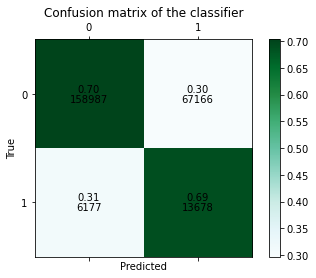

In [10]:
#confusion matrix
cm = confusion_matrix(Y_train, prediction_cv) 

cm_prob = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
plt.set_cmap("BuGn")
ax = fig.add_subplot(111)
cax = ax.matshow(cm_prob)
for i in range(2):
    for j in range(2):
        c = cm[j,i]
        c_prob = cm_prob[j,i]
        ax.text(i, j, str("%.2f"%c_prob), va='bottom', ha='center') 
        ax.text(i, j, str("%.0f"%c), va='top', ha='center') 
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [11]:
# Light Gradient Boosting model
def model(X_train,Y_train, X_test,Y_test):
     
    # LightGBMError: Do not support special JSON characters
    import re
    X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
  
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(X_train.columns))
    
    # Empty array for test predictions
    test_predictions = np.zeros(X_test.shape[0])    


    
    model = lgb.LGBMClassifier(
            boosting_type='goss',
            n_estimators=600,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            metric='custom', first_metric_only = True,
            silent=-1,
            verbose=-1 )  
     
   
    # Train the model on all the training data 
    model.fit( X_train, Y_train, eval_metric = own_eval_metric,
              eval_set = [(X_train, Y_train)],
              eval_names = ['train'],
              early_stopping_rounds = 100, verbose = 10)
    print('Best iteration:', model.best_iteration_)
     # Make predictions
    test_predictions = model.predict_proba(X_test, num_iteration =  model.best_iteration_)[:, 1]
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': X_test.columns, 'importance': model.feature_importances_})
    # save the model to disk
    filename = 'finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))

    return  feature_importances, test_predictions

In [12]:
fi, prediction_proba = model(X_train,Y_train, X_test,Y_test)

max : 0.20051280877269292
treshold  0.08
Training until validation scores don't improve for 100 rounds
max : 0.2972413635218974
treshold  0.08
max : 0.3102355715299558
treshold  0.08
max : 0.31756598978961104
treshold  0.08
max : 0.31814747830864676
treshold  0.08
max : 0.3213571117877338
treshold  0.08
max : 0.3209267187106522
treshold  0.08
max : 0.32186534191067057
treshold  0.08
max : 0.3231244705936219
treshold  0.08
max : 0.32503834619170807
treshold  0.08
[10]	train's own_eval_metric: 0.325038
max : 0.3288798333371489
treshold  0.08
max : 0.3286921086971452
treshold  0.08
max : 0.3287791030425128
treshold  0.08
max : 0.329397220759598
treshold  0.08
max : 0.3304548888532772
treshold  0.08
max : 0.33024427096449255
treshold  0.08
max : 0.33041368100547147
treshold  0.08
max : 0.33040452370595913
treshold  0.08
max : 0.3323962363499004
treshold  0.08
max : 0.3325015452942927
treshold  0.08
[20]	train's own_eval_metric: 0.332502
max : 0.33312424166113414
treshold  0.08
max : 0.3342

max : 0.3926466884915638
treshold  0.08
max : 0.39286646367986083
treshold  0.08
max : 0.3931091321169387
treshold  0.08
max : 0.39326938485840524
treshold  0.08
max : 0.3933563792037728
treshold  0.08
max : 0.39354410384377647
treshold  0.08
[190]	train's own_eval_metric: 0.393544
max : 0.3936173622398755
treshold  0.08
max : 0.394121013713056
treshold  0.08
max : 0.3939882328701266
treshold  0.08
max : 0.39417137886037407
treshold  0.08
max : 0.39439115404867103
treshold  0.08
max : 0.394684187633067
treshold  0.08
max : 0.39505505826331816
treshold  0.08
max : 0.395517501888693
treshold  0.08
max : 0.3952794121013713
treshold  0.08
max : 0.39544424349259405
treshold  0.08
[200]	train's own_eval_metric: 0.395444
max : 0.3957006478789405
treshold  0.08
max : 0.3960898331082164
treshold  0.08
max : 0.39635081614431905
treshold  0.08
max : 0.39657974863212836
treshold  0.08
max : 0.3968315743687187
treshold  0.08
max : 0.3965385407843227
treshold  0.08
max : 0.3965843272818846
treshold 

max : 0.42091069343650556
treshold  0.08
max : 0.42080996314186947
treshold  0.08
max : 0.4210480529291912
treshold  0.08
max : 0.42088780018772465
treshold  0.08
max : 0.4210984180765092
treshold  0.08
max : 0.4212128843204139
treshold  0.08
max : 0.42130903596529384
treshold  0.08
max : 0.4215379684531032
treshold  0.08
max : 0.4217989514892058
treshold  0.08
max : 0.4218722098853048
treshold  0.08
[380]	train's own_eval_metric: 0.421872
max : 0.4218401593370115
treshold  0.08
max : 0.4220553558755523
treshold  0.08
max : 0.422023305327259
treshold  0.08
max : 0.42217440076921314
treshold  0.08
max : 0.4222659737643369
treshold  0.08
max : 0.4218722098853048
treshold  0.08
max : 0.4220782491243332
treshold  0.08
max : 0.42238501865799777
treshold  0.08
max : 0.4225040635516586
treshold  0.08
max : 0.4225223781506834
treshold  0.08
[390]	train's own_eval_metric: 0.422522
max : 0.42251779950092716
treshold  0.08
max : 0.4225040635516586
treshold  0.08
max : 0.42276962523751743
treshold

max : 0.44214189235594425
treshold  0.08
max : 0.44213273505643186
treshold  0.08
max : 0.44230672374716695
treshold  0.08
max : 0.4423891394427783
treshold  0.08
[560]	train's own_eval_metric: 0.442389
max : 0.4428057965705913
treshold  0.08
max : 0.44282411116961606
treshold  0.08
max : 0.44294315606327694
treshold  0.08
max : 0.4431675099013301
treshold  0.08
max : 0.4430347290584007
treshold  0.08
max : 0.44328655479499096
treshold  0.08
max : 0.4432270323481605
treshold  0.08
max : 0.4436894759735354
treshold  0.08
max : 0.44377647031890294
treshold  0.08
max : 0.44366658272475445
treshold  0.08
[570]	train's own_eval_metric: 0.443667
max : 0.4441473409491541
treshold  0.08
max : 0.44426180719305874
treshold  0.08
max : 0.4444815823813557
treshold  0.08
max : 0.444463267782331
treshold  0.08
max : 0.4443854307364758
treshold  0.08
max : 0.44447242508184337
treshold  0.08
max : 0.44459146997550425
treshold  0.08
max : 0.4447791946155079
treshold  0.08
max : 0.44492571140770587
tres

In [13]:
prediction_t=calculate_pred(prediction_proba)

max : 0.39996341686482534
treshold  0.08


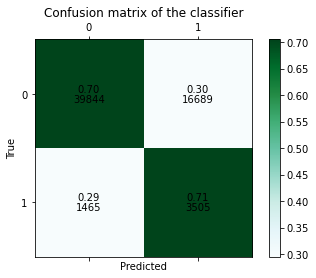

In [14]:
own_eval_metric(Y_test['TARGET'].to_numpy(),prediction_proba)
#confusion matrix
cm = confusion_matrix(Y_test, prediction_t) 

cm_prob = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure()
plt.set_cmap("BuGn")
ax = fig.add_subplot(111)
cax = ax.matshow(cm_prob)
for i in range(2):
    for j in range(2):
        c = cm[j,i]
        c_prob = cm_prob[j,i]
        ax.text(i, j, str("%.2f"%c_prob), va='bottom', ha='center') 
        ax.text(i, j, str("%.0f"%c), va='top', ha='center') 
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## <font color="blue"> 3. Feature Importances <a class="anchor" id="third-bullet"></a>

In [15]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

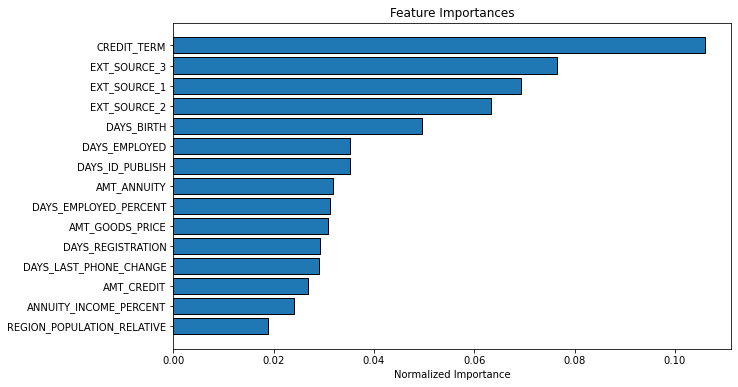

In [16]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(fi)

In [17]:
feature_importances_sorted.to_csv("../input/features_importance.csv",index=False)